In [31]:
import os 
import numpy as np
import librosa 
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
import shutil
from numba import jit, cuda

def get_file_descriptors(dirpath):
        directory={}
        dataset_path=dirpath
        cwd= os.getcwd()
        for i , (dirpath, dirname, filename) in enumerate(os.walk(dataset_path)):
            if(dirpath!=dataset_path):
                dirname=dirpath.split("/")[-1]
                files={}
                file_list=[]
                index=0
                filedict={}
                for file in filename:
                    f=file.split('.')[0]
                    fid=int(f.split('_')[-1])
                    filedict[fid]=file

                for fileid in sorted(filedict.keys()):
                    file=filedict[fileid]
                    filepath = os.path.join( dirpath,file)
                    if ( (filepath.endswith('.wav'))):
                        if(file.startswith('.')):
                            pass
                        else:
                            file_list.append(filepath)
                #file_list.sort()
                if(len(file_list)>0):
                    for filepath in file_list:
                        files[index]=filepath
                        index+=1
                    directory[dirname]=files
        return directory


In [26]:
directory=get_file_descriptors("../dataset/AEC-Challenge/datasets/synthetic")
json_path="./icassp_data_res.json"
json_directory = json.dumps(directory,indent=4)
with open(json_path, "w") as outfile:
    outfile.write(json_directory)

In [34]:
def tagstft(x,outfile_path):
    np.save(outfile_path,x)   
    
def generateDataset(input_dir,outputdir,fft_len,spec_dims):
    fft_len=fft_len
    spec_dims=spec_dims
    directory=get_file_descriptors(input_dir)
    spec_dict={}
    for key in directory.keys():
        spec_dict[key]={}
        k=0
        print(key)
        subset=list(directory[key].values())
        subset=subset[:720]
        for indx,filepath in tqdm(enumerate(subset)):
            file,sr=librosa.load(filepath,duration=10,sr=8000)
            file=librosa.util.normalize(file)
            frames=librosa.stft(file, n_fft=fft_len, hop_length=fft_len//4, win_length=fft_len, window='hann', center=True, dtype=None, pad_mode='constant')
            i=0
            for j in range(0,(frames.shape[1]-spec_dims[1]),spec_dims[1]):
                filename=key+"_fileid_"+str(indx)+"_"+str(i)+".npy"
                out_file=os.path.join(outputdir,filename)
                y=frames[:,j:j+spec_dims[1]]
                tagstft(y,out_file)
                spec_dict[key][k]=out_file
                k+=1
                i+=1
    json_path="./icassp_LUT_512x64_RES.json"
    json_directory = json.dumps(spec_dict,indent=4)
    with open(json_path, "w") as outfile:
        outfile.write(json_directory)

In [35]:
dir_path= "../dataset/AEC-Challenge/datasets/synthetic"
spec_dims=(512,64)
fft_len=1023
dir="../dataset/AEC-Challenge/datasets/data_RES"
shutil.rmtree(dir)
os.mkdir(dir)
generateDataset(dir_path,dir,fft_len=fft_len,spec_dims=spec_dims)

echo_signal


720it [01:17,  9.29it/s]


residualecho


720it [00:02, 245.68it/s]


nearend_mic_signal


720it [01:17,  9.32it/s]


farend_speech


720it [01:17,  9.25it/s]


residual


720it [00:02, 243.86it/s]


nearend_speech


720it [01:18,  9.15it/s]


Sanity check 

In [22]:
ar=[]
inc=4
ar=np.zeros((spec_dims[0],spec_dims[1]*inc))
j=0
offset=0
for i in range(offset,offset+inc):
    a=np.load("../dataset/AEC-Challenge/datasets/data_RES/echo_signal_fileid_29_"+str(i)+".npy")
    ar[:,spec_dims[1]*j:spec_dims[1]*j+spec_dims[1]]=abs(a)
    j+=1

print(ar.shape)

(512, 256)


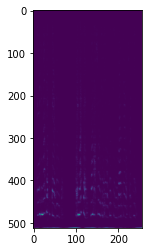

In [23]:
plt.figure()
plt.imshow((np.flip(abs(ar),axis=0)))

In [24]:
#sanity check for fft sizes
tone=librosa.tone(440,sr=8000,duration=1)
stft_tone=librosa.stft(tone,n_fft=1023,hop_length=1023//4,center=True)
print(stft_tone.shape)

(512, 32)
